# between and within ratio (組間和組內比)

<font size = 5 color = orange>此比較用於單個特徵, 去比較不同 label(y值) 對應的數值.</font>

期望來說, 相同 labe 所對應的數值差異越小越好; 不同的 label 所對應的數值差異越大越好.

比較方法是使用 ANOVA, 做法和 One-way ANOVA 一樣(參考 : 分析相關/015.假設檢定/03.ANOVA.ipynb). 但是我們要的是"有差異", 所以假設檢定得到的 p_value 越小越好. 主要是因為 $H_0$ 基本上是設 : 平均數相等.



![參考圖片](https://imgur.com/QLUorPT.jpg)

## One-way ANOVA table

<font size = 5>符號 : </font>

*   k : 組數

*   N : 總樣本數 ( $\sum n_i$ )

*   $y_{k,i}$ : 第k組第i個觀察值 (上面表示成 $x_{i,k}$)

*   $\bar{y_{k}}$ : 第k組觀察值的平均值 (上面表示成 $\bar{x_{k}}$)

*   $\bar{y}$    : 所有觀察值的平均值 (上面表示成 $\bar{\bar{x}}$)

*   $SS_T (總變異) : \sum\limits_{k}\sum\limits_{i}(y_{k,i} - \bar{y})^2 ~=~ n_T\sigma_T^2 ~=~ (n_T-1)s_T^2 $

*   $SS_G (組間變異, SS_A (A 因子的變異)) : \sum\limits_{k}n_k(\bar{y_{k}} - \bar{y})^2 = SS_T - SS_W = SS_T - SS_E$

*   $SS_W (組內變異, SS_E) : \sum\limits_{k}\sum\limits_{i}(y_{k,i} - \bar{y_{k}})^2  = \sum\limits_{k}(n_k-1)(\frac{1}{n_k-1}\sum\limits_{i}(y_{k,i} - \bar{y_{k}})^2) = \sum\limits_{k} (n_k-1)s_k^2$

*   $SS_T = SS_G + SS_W$

*   $F^*$   : 若 $F^* > F_\alpha(k-1,n-k)$，則 $ reject ~~H_0 $ 。


<img src="https://i.imgur.com/R2OoUE9.png" width="60%" height="60%">

### python

先舉一個 One-way ANOVA table 的例子, 其中 label 的數量為 G 個.

以下可以想像成計算一個參數的 p_value

In [398]:
from pickle import FALSE
import numpy as np
import pandas as pd
import scipy.stats as ss

## 種子碼
np.random.seed(5)

## input
G = 4 # label
min_n = 12 # 各 label 的數量最少個數
max_n = 30 # 各 label 的數量最多個數

##建立資料
data = {}
n = []
for i in range(G):
    # ni 是隨機各個 label 的資料數量, 當然也可以直接生成 X 然後隨機生成 Y, 
    # 但因為計算時還是必須各別提出, 所以這裡先這樣做.
    # 並且若隨機生成 Y, 其 label 數量會有分配太平均的問題(當然也可能不是問題).
    ni = np.random.randint(min_n, max_n)
    Loc = np.random.normal(loc = 0, scale = 1 ,size = 1)[0]
    Scale = np.random.randint(1, 2)
    data["母體{}".format(i+1)] = np.random.normal(loc = Loc, scale = Scale ,size = ni)
    n.append(ni)
N = np.sum(n) #總樣本數

##處理資料(python 不同長度製作成data frame很麻煩，所以直接處理資料在製作，之後計算也比較方便)
pre_data = {"ni"   : [ len(data[i]) for i in data.keys()],
            'xbar' : [ np.mean(data[i]) for i in data.keys()] ,
            's2'  :  [ np.var(data[i],ddof = 1) for i in data.keys()]} # ddof是自由度, = 1 是計算樣本方差
DF = pd.DataFrame(pre_data)
DF.index = data.keys()
DF

##run
all_mean = DF['ni'] * DF['xbar']/np.sum(DF['ni']) #sum(ni*xbar/sum(ni))

SSG =np.sum(DF['ni']*(DF['xbar']-all_mean)**2)  #sum(nk(xbar-xbarbar))
SSW = np.sum((DF['ni']-1) * DF['s2'] ) #sum((nk-1)*sk^2)
SST = SSG + SSW

SS = [SSG,SSW,SST]
df = [G-1,N-G,N-1]
MS = [SS[0]/df[0],SS[1]/df[1],np.NaN]
F = [ MS[0]/MS[1],np.NaN,np.NAN]
p_value = [1 - ss.f.cdf(F[0], G-1, N-G), np.NaN, np.NAN]

ANOVA_df = pd.DataFrame([SS, df, MS, F, p_value]).T
ANOVA_df.index = ["因子(組間)","隨機(組內)","總和"]
ANOVA_df.columns = ["平方和","自由度","平均平方和","F", "p_value"]

ANOVA_df #用print 會沒對齊



,平方和,自由度,平均平方和,F,p_value
因子(組間),15.191496,3.0,5.063832,4.770413,0.004498
隨機(組內),71.121045,67.0,1.061508,NaN,NaN
總和,86.312541,70.0,NaN,NaN,NaN


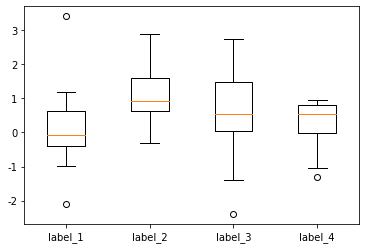

In [399]:
import matplotlib.pyplot as plt

Data = [i for i in data.values()]

# 繪製盒鬚圖
plt.boxplot(Data)

# 設置細節
Keys = ['label_{}'.format(i+1) for i in range(len(data.keys()))]
plt.xticks(range(1, len(Keys) + 1 ) , Keys)

plt.show()

### python

模擬多個特徵, 多個值, 進行特徵處理.

In [400]:
import numpy as np
import pandas as pd

# 設定種子碼
np.random.seed(4)

##########
### input
##########

Ft = 10 # 特徵數量
K = 5 # label 數量
N = 10000 # 資料量


##############
### simulation
##############

# 隨機生成各個 label 的結果數
rand_prop = np.random.randint(20, 80, K)  # 隨機比率
probabilities = rand_prop / np.sum(rand_prop) # 計算機率
sample = np.random.multinomial(N, probabilities) # 計算每個 label 的個數

# 模擬各個特徵值

data = {}

# Y
Y_list = [[i+1]*sample[i] for i in range(K)]
def merged_list(List): # 合併 list
    merged_L = []
    for i in List:
        merged_L.extend(i)
    return merged_L
data['Y'] = merged_list(Y_list)

# 各個特徵
def simulation_data(sample, mean_range, scale_range): # 使用 normal 模擬值
    data = []
    for i in range(len(sample)):
        loc = np.random.uniform(mean_range[0], mean_range[1])
        scale = np.random.uniform(scale_range[0], scale_range[1])
        data += list( np.round( np.random.normal(loc, scale, sample[i]), 3))
    return data

mean_range = [0, 0]
scale_range = [0, 20]
scale_range_Diff = (scale_range[1] - 1)/Ft # 縮小 scale 用
for i in range(Ft):
    mean_range[0] -= 0.1 #放大mean 的 range
    mean_range[1] += 0.1
    scale_range[1] -= scale_range_Diff
    # 因為平均數差越遠且標準差越小的結果越好, 所以理論上來說 feature 越後面 p_value 會越小
    data['feature_{}'.format(i+1)] = simulation_data(sample, mean_range, scale_range)

DF = pd.DataFrame(data)
DF

,Y,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,1,-21.483,-0.081,-2.029,-2.744,1.191,-0.886,1.517,1.381,-1.277,-1.423
1,1,10.320,0.354,1.370,15.637,5.354,0.546,-1.145,0.583,0.204,-1.137
2,1,16.371,-0.092,0.418,-1.619,3.390,-0.190,1.965,-0.259,-0.870,-1.198
3,1,7.563,0.769,1.785,0.510,-4.384,-0.504,-0.642,1.009,-0.944,-0.112
4,1,-1.185,0.248,0.261,-8.441,-4.175,-0.743,0.268,-1.024,-0.132,-1.607
...,...,...,...,...,...,...,...,...,...,...,...
9995,5,-0.690,1.725,1.389,7.716,10.623,5.414,0.201,5.380,-0.591,0.148
9996,5,2.812,-12.168,10.877,12.433,7.468,-2.848,1.864,2.489,-0.698,1.646
9997,5,4.350,9.776,14.716,-2.852,11.839,4.486,-4.457,-0.228,-0.871,1.423
9998,5,-4.675,-8.967,-6.512,-10.611,-0.601,2.699,10.756,1.085,-0.573,0.778


### 畫 feature_1 和 feature_10 的盒鬚圖試試

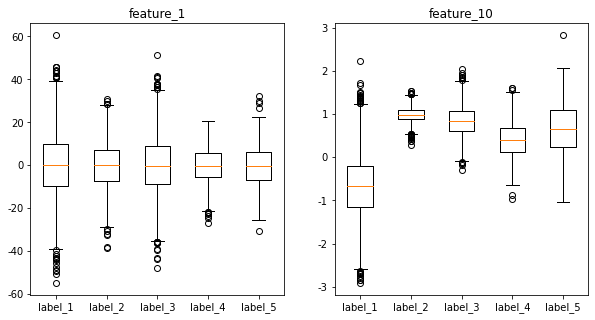

In [401]:
import matplotlib.pyplot as plt

# 取出 Y 的 label 種類
Y_label = list(set(DF['Y'].values))

# 目標的 X
colname1 = 'feature_1'
colname2 = 'feature_{}'.format(Ft)
X1 = [DF[ DF['Y'] == i][colname1].values for i in Y_label]
X2 = [DF[ DF['Y'] == i][colname2].values for i in Y_label]

# 繪圖
box_name = ['label_{}'.format(i) for i in Y_label] # 設定每張圖的盒鬚名

# 創建畫布與子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(X1)
ax1.set_title(colname1)
ax1.set_xticks(Y_label, box_name)

ax2.boxplot(X2)
ax2.set_title(colname2)
ax2.set_xticks(Y_label, box_name)

plt.show()

### 計算每個特徵的 p_value

In [402]:
import scipy.stats as ss
dependent_name = 'Y'
feature_name = ['feature_{}'.format(i+1) for i in range(Ft)]

def one_way_ANOVA_pvalue(data, dependent_name, feature_name):

    # 分配 data
    Y = data[dependent_name].values
    data_numb = len(Y)
    label_list = list(set(Y)) # label 種類
    label_numb = len(label_list)
    each_label_numb = [np.sum(Y == i) for i in label_list] # 各個 label 個數

    # 求得每個 特徵 的每個 label 的 mean 和 sd
    X_mean_list = [np.mean(data[data[dependent_name] == i].values.T[1:], axis = 1) for i in label_list]
    X_std_list =  [np.var( data[data[dependent_name] == i].values.T[1:], ddof = 1, axis = 1) for i in label_list] # ddof是自由度, = 1 是計算樣本方差
    feature_mean_list = np.mean(data[feature_name].values, axis = 0)

    # 計算每個特徵的變異(SS)
    SSG_list = np.sum(np.array(
        [ each_label_numb[i] * (X_mean_list[i] - feature_mean_list)**2 for i in range(label_numb) ]
        ), axis = 0)
    SSW_list = np.sum(np.array(
        [(each_label_numb[i] - 1) * X_std_list[i] for i in range(label_numb)]
        ), axis = 0)

    # 計算平均平方和(MS)
    MSG_list = SSG_list / (label_numb - 1)
    MSW_list = SSW_list / (data_numb - label_numb)

    # 統計量(F)
    F_list = MSG_list / MSW_list

    # P_values
    p_values = 1 - ss.f.cdf(F_list, (label_numb - 1), (data_numb - label_numb))

    return(p_values)

p_values = one_way_ANOVA_pvalue(DF, dependent_name, feature_name)
print(p_values)

[8.26102951e-01 2.27759356e-01 1.78155829e-01 3.10033748e-02
 2.35434987e-04 2.41967397e-05 1.11022302e-16 1.11022302e-16
 1.11022302e-16 1.11022302e-16]


In [417]:
reject_list = [feature_name[i] for i in range(len(feature_name)) if p_values[i] < 0.05]
print('以下特徵經過檢定後, 推測它們的值和 label 有關 : ' +  ', '.join(reject_list))

以下特徵經過檢定後, 推測它們的值和 label 有關 : feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10
